In [ ]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pickle
import datetime
from utils.es_utils import *
from utils.env_utils import *
from utils.train_utils import *
from models.Buffer import Buffer
from models.PredatorPolicy import PredatorPolicy
from models.PreyPolicy import PreyPolicy
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
from models.Buffer import Pool
from utils.env_utils import *
from utils.eval_utils import *
from utils.train_utils import pretrain_policy_with_validation
from custom_marl_aquarium.aquarium_v0 import parallel_env

c:\Users\janni\anaconda3\envs\test2\lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [ ]:
# Create training folder
path = rf"..\data\2. Training\training\BC"
timestamp = datetime.datetime.now().strftime("%d.%m.%Y_%H.%M")
folder_name = f"BC Training - {timestamp} - Video Data"
save_dir = os.path.join(path, folder_name)
os.makedirs(save_dir, exist_ok=True)

# Expert Data
traj_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\yolo_detected'
couzin_path = rf'..\data\1. Data Processing\processed\couzin'
hl_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\hand_labeled'
ftw_path = rf'..\data\1. Data Processing\processed\video\3. full_track_windows'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pred_policy = PredatorPolicy().to(device)
pred_policy.set_parameters(init=True)

prey_policy = PreyPolicy(gain=0.0).to(device)
prey_policy.set_parameters(init=True)

expert_buffer = Buffer(pred_max_length=23000, prey_max_length=200000, device="cpu")

start_frame_pool = Pool(max_length=12100, device="cpu")
start_frame_pool.generate_startframes(ftw_path)
print(f"Start frames in pool: {len(start_frame_pool)}")

Start frames in pool: 11978


In [ ]:
# Load Expert Data from local storage
print("Expert Buffer is empty, load data...")
expert_buffer.add_expert(traj_path)
#expert_buffer.clear(p=80)               # Reduce ratio of non-attack data by 90%. now ~equal
expert_buffer.add_expert(hl_path)       # hand-labeled data | Pred: 1057 | Prey: 33824
expert_buffer.add_expert(hl_path)
expert_buffer.add_expert(hl_path)

len_exp_pred, len_exp_prey = expert_buffer.lengths()
print("Storage of Predator Expert Buffer: ", len_exp_pred)
print("Storage of Prey Expert Buffer: ", len_exp_prey, "\n")

Expert Buffer is empty, load data...
Storage of Predator Expert Buffer:  23000
Storage of Prey Expert Buffer:  200000 



[PREDATOR] Epoch 01 | Train Loss: 0.551455 | Val Loss: 0.312605
[PREDATOR] Epoch 02 | Train Loss: 0.473614 | Val Loss: 0.448017
[PREDATOR] Epoch 03 | Train Loss: 0.359872 | Val Loss: 0.357088
[PREDATOR] Epoch 04 | Train Loss: 0.383174 | Val Loss: 0.469701
[PREDATOR] Epoch 05 | Train Loss: 0.414387 | Val Loss: 0.341115
[PREDATOR] Epoch 06 | Train Loss: 0.412624 | Val Loss: 0.230211
[PREDATOR] Epoch 07 | Train Loss: 0.314023 | Val Loss: 0.308034
[PREDATOR] Epoch 08 | Train Loss: 0.346356 | Val Loss: 0.276116
[PREDATOR] Epoch 09 | Train Loss: 0.306943 | Val Loss: 0.355398
[PREDATOR] Epoch 10 | Train Loss: 0.379787 | Val Loss: 0.373196
[PREDATOR] Epoch 11 | Train Loss: 0.318002 | Val Loss: 0.239339
[PREDATOR] Epoch 12 | Train Loss: 0.342691 | Val Loss: 0.309435
[PREDATOR] Epoch 13 | Train Loss: 0.360587 | Val Loss: 0.195608
[PREDATOR] Epoch 14 | Train Loss: 0.342756 | Val Loss: 0.348991
[PREDATOR] Epoch 15 | Train Loss: 0.361427 | Val Loss: 0.294161
[PREDATOR] Epoch 16 | Train Loss: 0.4093

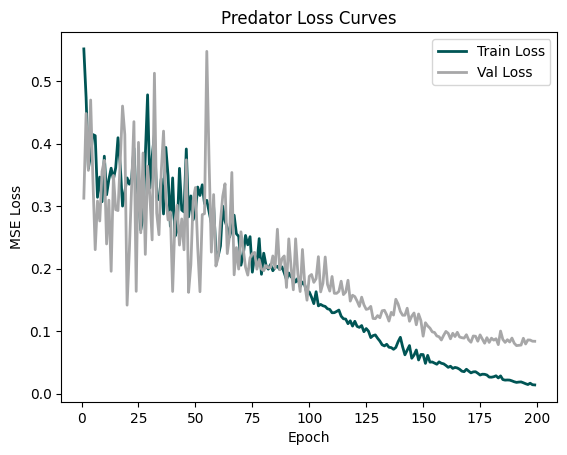

In [ ]:
pred_policy, pred_logs = pretrain_policy_with_validation(pred_policy, prey_policy, expert_buffer, role='predator', val_ratio=0.2, pred_bs=64, prey_bs=2048, epochs=500, lr=1e-3, early_stopping=True, patience=100, device=device)
torch.save(pred_policy, os.path.join(save_dir, "bc_pred_policy.pt"))

with open(os.path.join(save_dir, "bc_pred_logs.pkl"), "wb") as f:
    pickle.dump(pred_logs, f)

[PREY] Epoch 01 | Train Loss: 0.487889 | Val Loss: 0.490810 | Pred Gain: 2.7033333349635313e-09
[PREY] Epoch 02 | Train Loss: 0.478667 | Val Loss: 0.451037 | Pred Gain: 0.3068550229072571
[PREY] Epoch 03 | Train Loss: 0.460527 | Val Loss: 0.413186 | Pred Gain: 0.10863146930932999
[PREY] Epoch 04 | Train Loss: 0.446330 | Val Loss: 0.446188 | Pred Gain: 0.9946746826171875
[PREY] Epoch 05 | Train Loss: 0.415873 | Val Loss: 0.468056 | Pred Gain: 1.7524462436746546e-10
[PREY] Epoch 06 | Train Loss: 0.430078 | Val Loss: 0.444731 | Pred Gain: 0.005376660265028477
[PREY] Epoch 07 | Train Loss: 0.425018 | Val Loss: 0.464155 | Pred Gain: 0.008052644319832325
[PREY] Epoch 08 | Train Loss: 0.426013 | Val Loss: 0.447216 | Pred Gain: 0.009314651601016521
[PREY] Epoch 09 | Train Loss: 0.442855 | Val Loss: 0.454792 | Pred Gain: 0.03855416923761368
[PREY] Epoch 10 | Train Loss: 0.415649 | Val Loss: 0.457727 | Pred Gain: 0.04634618014097214
[PREY] Epoch 11 | Train Loss: 0.414478 | Val Loss: 0.464699 | P

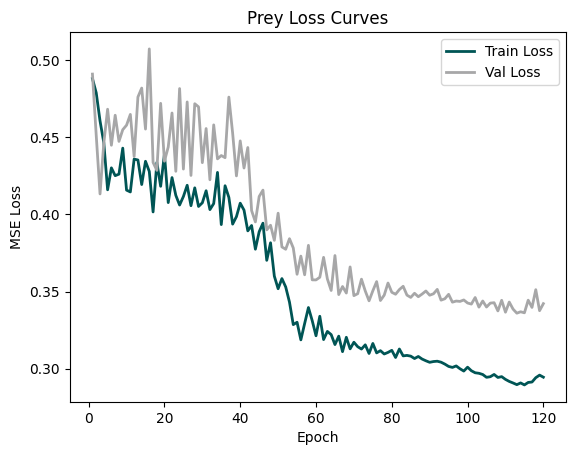

In [ ]:
prey_policy, prey_logs = pretrain_policy_with_validation(prey_policy, pred_policy, expert_buffer, role='prey', val_ratio=0.2, pred_bs=64, prey_bs=2048, epochs=1000, lr=1e-3, early_stopping=True, patience=100, device=device)
torch.save(prey_policy, os.path.join(save_dir, "bc_prey_policy.pt"))

with open(os.path.join(save_dir, "bc_prey_logs.pkl"), "wb") as f:
    pickle.dump(prey_logs, f)

In [ ]:
env = parallel_env(use_walls=True)
positions = start_frame_pool.sample(n=1)
env.reset(options=positions)
metrics = run_policies(env, pred_policy, prey_policy)

Press 'q' to end simulation.


FileNotFoundError: No such file or directory: 'c:\Users\janni\anaconda3\envs\test2\lib\site-packages\custom_marl_aquarium\env\assets\prey.png'.